# Homework 6 ResNet and DenseNet


In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAvgPool2D, Activation,AveragePooling2D
import matplotlib.pyplot as plt


In [2]:

train_ds, test_ds = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteQW6P5R/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteQW6P5R/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [3]:
def prepare_cifar10_data(cifar10):
    # convert data from uint8 to float32
    cifar10 = cifar10.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
    cifar10 = cifar10.map(lambda img, target: ((img / 128.) - 1., target))
    # create one-hot targets
    cifar10 = cifar10.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # cache this progress in memory, as there is no need to redo it; it is deterministic after all
    cifar10 = cifar10.cache()
    # shuffle, batch, prefetch
    cifar10 = cifar10.shuffle(10000)
    cifar10 = cifar10.batch(32)
    cifar10 = cifar10.prefetch(20)
    # return preprocessed dataset
    return cifar10



## ResNet



In [13]:
class ResidualBlock(tf.keras.Model):
  def __init__(self,n_filters=64, out_filters=64, mode="normal"):
    super(ResidualBlock, self).__init__()
    self._mode = mode
    self._out = None
    self._out_filters = out_filters
    self._n_filter = n_filters
    self.batchNorm1 = BatchNormalization()
    self.active1 = Activation(tf.nn.relu)
    self.conv_layer1 = Conv2D(filters=self._n_filter, kernel_size =1, padding="same", activation=tf.nn.relu)
    self.batchNorm2 = BatchNormalization()
    self.active2 = Activation(tf.nn.relu)
    
    if self._mode == "normal":
      #print(self._mode,1)
      self.conv_layer2 = Conv2D(filters=self._n_filter, kernel_size =(3,3), padding="same")
      self.layer_x = Conv2D(filters=self._out_filters, kernel_size=(1,1))
    
    elif self._mode == "strided":
      #print(self._mode,2)
      self.conv_layer2 = Conv2D(filters=self._n_filter, kernel_size =(3,3), padding="same", strides=(2,2))

      self.layer_x = MaxPool2D(pool_size=(1,1), strides=(2,2))
        

    elif self._mode == "constant": 
      #print(self._mode,3)
      self._out_filters = self._n_filter
      self.conv_layer2 = Conv2D(filters=self._n_filter, kernel_size =(3,3), padding="same")
      self.layer_x = lambda y : y
   
    
    self.batchNorm3 = BatchNormalization()
    self.active3 = Activation(tf.nn.relu)

    self.outLayer = Conv2D(filters=self._out, kernel_size =(1,1))    
    self.conv_layer3 = Conv2D(filters=out_filters, kernel_size =1, padding="same", activation=tf.nn.relu)


  @tf.function
  def call(self, inputs):

    if self._out == None:
      if self._mode == "strided":
        self._out = inputs.shape[-1]
        self.outLayer = Conv2D(filters=inputs.shape[-1], kernel_size =(1,1))
      else:
        self._out = self._out_filters
        self.outLayer = Conv2D(filters=self._out_filters, kernel_size =(1,1))
    return(self.performance(inputs))

  @tf.function  
  def performance(self, inputs):
    x = self.batchNorm1(inputs)
    x = self.active1(x)
    x = self.conv_layer1(x)
    x = self.batchNorm2(x)
    x = self.active2(x)
    x = self.conv_layer2(x)
    x = self.batchNorm3(x)
    x = self.active3(x)
    x = self.outLayer(x)
    x = tf.keras.layers.Add()([x, self.layer_x(inputs)])

    return(x)

 

class ResNet(tf.keras.Model):
  def __init__(self):
    super(ResNet, self).__init__()
    self.conv_layer1 = Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    self.resBlock1 = ResidualBlock(mode = "strided")
    self.resBlock2 = ResidualBlock(mode="constant")
    self.resBlock3 = ResidualBlock()
    self.global_pooling = GlobalAvgPool2D()
    self.dense1 = Dense(16,kernel_regularizer='l2',bias_regularizer = 'l2',activity_regularizer= 'l2', activation=tf.nn.sigmoid)
    self.out = Dense(10, activation=tf.nn.softmax)

  @tf.function
  def call(self, inputs):
    x = self.conv_layer1(inputs)
    x = self.resBlock1(x)
    x = self.resBlock2(x)
    x = self.resBlock3(x)
    x = self.global_pooling(x)
    x = self.dense1(x)
    x = self.out(x)
    #print("done")
    return(x)


## DenseNet

In [5]:
class TransitionLayers(tf.keras.Model):
  def __init__(self):
    super(TransitionLayers, self).__init__()
    self.batchNorm1 = BatchNormalization()
    self.active1 = Activation(tf.nn.relu)
    self.conv_layer1 = Conv2D(filters=128, kernel_size =1, padding="same", activation=tf.nn.relu)
    self.avgPool1 = AveragePooling2D(pool_size=(2,2), strides = (2,2), padding = 'valid')
  
  @tf.function
  def __call__(self,inputs):
      x =  self.batchNorm1(inputs)
      x =  self.active1(x)
      x =  self.conv_layer1(x)
      x =  self.avgPool1(x)
      return(x)

class DenseBlock(tf.keras.Model):
    def __init__(self, n_filters = 128, new_channels = 32):
      super(DenseBlock,self).__init__()
      self.batchNorm1 = BatchNormalization(epsilon=1.001e-05)
      self.active1 = Activation(tf.nn.relu)
      self.conv_layer1 = Conv2D(filters=n_filters, kernel_size =(1,1), padding="same", activation=tf.nn.relu)
      self.batchNorm2 = BatchNormalization(epsilon=1.001e-05)
      self.active2 = Activation(tf.nn.relu)
      self.conv_layer2 = Conv2D(filters=new_channels, kernel_size =(3,3), padding="same", activation=tf.nn.relu)
      self.out = tf.keras.layers.Concatenate(axis=3)
    
    @tf.function
    def __call__(self,inputs):
      x =  self.batchNorm1(inputs)
      x =  self.active1(x)
      x =  self.conv_layer1(x)
      x =  self.batchNorm2(x)
      x =  self.active2(x)
      x =  self.conv_layer2(x)
      x =  self.out([inputs,x])
      return(x)


class DenseNet(tf.keras.Model):
  def __init__(self):
    super(DenseNet, self).__init__()
    self.stem1 = tf.keras.layers.ZeroPadding2D(padding=(3, 3), data_format=None)
    self.stem2 = Conv2D(filters = 64,kernel_size=(7,7), strides=(2,2),padding="valid",use_bias=False)
    self.stem3 = BatchNormalization(epsilon=1.001e-05)
    self.stem4 = Activation(tf.nn.relu)
    self.extrPad1 = tf.keras.layers.ZeroPadding2D(padding=(1, 1), data_format=None)
    self.extrPad2 = MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid")
    self.denseBlock1 = DenseBlock()
    self.trans1 = TransitionLayers()
    self.denseBlock2 = DenseBlock()
    self.trans2 = TransitionLayers()
    self.denseBlock3 = DenseBlock()
    self.trans3 = TransitionLayers()
    self.denseBlock4 = DenseBlock()
    self.batchNorm1 = BatchNormalization(epsilon=1.001e-05)
    self.active1 = Activation(tf.nn.relu)
    self.avgPool1 = GlobalAvgPool2D()
    self.out = Dense(10, activation=tf.nn.softmax)

  @tf.function
  def __call__(self,inputs):
    x =  self.stem1(inputs)
    x =  self.stem2(x)
    x =  self.stem3(x)
    x =  self.stem4(x)
    x =  self.extrPad1(x)
    x =  self.extrPad2(x)
    x =  self.denseBlock1(x)
    x =  self.trans1(x)
    x =  self.denseBlock2(x)
    x =  self.trans2(x)
    x =  self.denseBlock3(x)
    x =  self.trans3(x)
    x =  self.denseBlock4(x)
    x =  self.batchNorm1(x)
    x =  self.active1(x)
    x =  self.avgPool1(x)
    x =  self.out(x)
    return(x)
 

## Baseline code basic CNN

In [6]:
class Cifar10ConvModel(tf.keras.Model):

    def __init__(self):
        super(Cifar10ConvModel, self).__init__()
        self.conv_layer1 = Conv2D(filters=24, kernel_size=3, padding='same', activation=tf.nn.relu)
        self.conv_layer2 = Conv2D(filters=24, kernel_size=3, padding='same', activation=tf.nn.relu)
        self.pooling1 = MaxPool2D(pool_size=2, strides=2)
        self.conv_layer3 = Conv2D(filters=48, kernel_size=3, padding='same', activation=tf.nn.relu)
        self.conv_layer4 = Conv2D(filters=48, kernel_size=3, padding='same', activation=tf.nn.relu)
        self.global_pooling = GlobalAvgPool2D()
        self.dense1 = Dense(16,kernel_regularizer='l2',bias_regularizer = 'l2',activity_regularizer= 'l2', activation=tf.nn.sigmoid)
        self.out = Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        return self.out(self.dense1(self.global_pooling(
            self.conv_layer4(self.conv_layer3(self.pooling1(self.conv_layer2(self.conv_layer1(inputs))))))))

In [15]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy




## Train ResNet

In [19]:

train_dataset = train_ds.apply(prepare_cifar10_data)
test_dataset = test_ds.apply(prepare_cifar10_data)


tf.keras.backend.clear_session()

# For showcasing we only use a subset of the training and test data (generally use all of the available data!)


### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = ResNet()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

# testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    # training (and checking in with training)
    epoch_loss_agg = []
    for input, target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)

    # track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    # testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3), ("training", "test", "test accuracy"))
plt.show()


Epoch: 0 starting with accuracy 0.09994009584664537


ValueError: ignored

## Train Baseline CNN

In [18]:

train_dataset = train_ds.apply(prepare_cifar10_data)
test_dataset = test_ds.apply(prepare_cifar10_data)


tf.keras.backend.clear_session()

# For showcasing we only use a subset of the training and test data (generally use all of the available data!)


### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = Cifar10ConvModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

# testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    # training (and checking in with training)
    epoch_loss_agg = []
    for input, target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)

    # track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    # testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3), ("training", "test", "test accuracy"))
plt.show()


Epoch: 0 starting with accuracy 0.10003993610223642


ValueError: ignored

## Train DenseNet

Epoch: 0 starting with accuracy 0.1053314696485623
Epoch: 1 starting with accuracy 0.4894169329073482
Epoch: 2 starting with accuracy 0.5614017571884984
Epoch: 3 starting with accuracy 0.6282947284345048
Epoch: 4 starting with accuracy 0.6524560702875399
Epoch: 5 starting with accuracy 0.6705271565495208
Epoch: 6 starting with accuracy 0.6866014376996805
Epoch: 7 starting with accuracy 0.7005790734824281
Epoch: 8 starting with accuracy 0.7216453674121406
Epoch: 9 starting with accuracy 0.7072683706070287


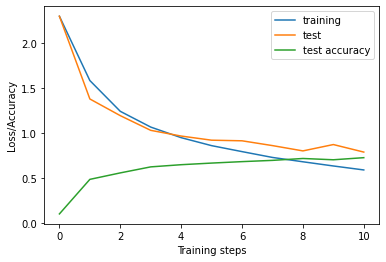

In [10]:

train_dataset = train_ds.apply(prepare_cifar10_data)
test_dataset = test_ds.apply(prepare_cifar10_data)


tf.keras.backend.clear_session()

# For showcasing we only use a subset of the training and test data (generally use all of the available data!)


### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = DenseNet()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

# testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    # training (and checking in with training)
    epoch_loss_agg = []
    for input, target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)

    # track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    # testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3), ("training", "test", "test accuracy"))
plt.show()
